In [1]:
import time
import numpy as np
import matplotlib.pyplot as plt
import os

from astropy.io import fits
from skimage.filters import threshold_otsu
from scipy.ndimage import shift
from scipy.optimize import curve_fit

np.seterr(all="ignore")

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

In [ ]:
'''Help


# ---------------------------------------- Переменные -----------------------------------------------------------------
nx - ширина окна для автокорреляции зрачка, должно быть минимум в 2 раза больше, чем ширина зрачка [pix]
I0c - индикатор для зрачка  
f_scale - шаг по частоте, [м^-1]
delta - шаг апертуры или же просто размер 1ого пикселя, [м] 

def frequency_dim - создание пространства частот 
def c_jk - создание коэффициента передачи зрачка
def move_gamma - сдвиг гаммы относительно центра взависимости от скорости ветра
# ---------------------------------------------------------------------------------------------------------------------

Ex:

Для примера пусть Cn2 соответствует качеству изображения, равному 1 угловой секунде (типичное качество изображения) на длине 
волны 500 нм. Для удобства величину Cn2(z)dz рассматриваем как одну величину, обозначим ее C. Тогда:
    beta = 0.98 * lambda/r0 = 1, следовательно: r0 = 0.98*lambda*206265,
Пусть мы наблюдаем в зените, тогда параметр Фрида будет:
    r0 = (0.423*k^2 * C)^(-3/5), где k = 2*pi/lambda.
Далее можно просто выразить и посчитать С
    Cn2_ex = pow((0.98*lambda_)*206265, -5/3) / (0.423*pow(2*np.pi/lambda_, 2))
    
А вообще, нам неважно какое значение Cn2 брать, ответ всегда будет верным
# ---------------------------------------------------------------------------------------------------------------------

Подложки на изображении-результате кросс-корреляции быть не должно (ее видно если брать модуль от мнимой части). Видно, 
что значения мнимой части очень маленькие, поэтому можно выводить сразу действительную часть.
Черные области рядом с пиками - зоны Френеля. По радиусу этих зон можно посчитать дистанцию распространения
'''
print()

In [2]:
# ------------------------ Апертурный фильтр ----------------------
def aperture_func(fx, fy, delta): 
    res = np.abs(np.sinc(delta*fx)*np.sinc(delta*fy))**2
    res[np.isnan(res)] = 0
    return res
    
# ------------------------ Модуль |f|^11/3 -------------------------
def abs_f(fx, fy):
    res = pow(np.sqrt(fx**2+fy**2), -11./3.)
    res[np.isnan(res)] = 0
    return res

# ----------------------- Фильтр Френеля --------------------------------
def ffilter(z, lambda_): 
    global fx, fy
    res = pow(np.sin(np.pi*z*lambda_*(fx**2+fy**2)), 2) / pow(lambda_, 2)
    res[np.isnan(res)] = 0
    return res

# ------------------------- Коэффициент передачи зрачка ------------------
def c_jk():
    global frame
    nx = 2 * frame.shape[0] + 1
    I0c = (frame != 0) * int(1)
    I0c = np.pad(I0c, ((nx - I0c.shape[0])//2, (nx - I0c.shape[1])//2), 'constant', constant_values=(0))
    res = np.fft.fftshift(np.real(np.fft.ifft2(np.fft.fft2(I0c)*np.fft.fft2(I0c).conjugate())))
    res /= np.max(res)
    return res, nx

# --------------------------- Спектральный фильтр -------------------------------------
def sfilter(z=None):
    global D, frame, lambda_max, f_lambda, nx
    coeff = 100
    k = 1000*coeff
    lambda_max_new = int(lambda_max*coeff)
    lambdas = np.linspace(0, lambda_max_new, k) * pow(10, -9) # [м]

    tail = np.zeros((len(lambdas) - len(f_lambda)))
    f_lambda_new = np.append(f_lambda, tail)
    res_fft = pow((np.imag(np.fft.fft(f_lambda_new/lambdas))), 2)

    delta_lambdas = (lambda_max_new / len(lambdas)) * pow(10, -9) # период дискретизации, шаг по частоте [м]
    omega_lambdas_scale = 1 / (delta_lambdas) # максимальное значение по частоте, [м^-1]

    delta = D/frame.shape[0] # шаг субапертуры, период дискретизации (то, насколько одно значение отстает от следующего) [м]
    f_scale = 1/(delta*nx) # шаг по частоте, [м^-1]

    xx, yy = np.meshgrid(np.linspace(-nx//2, nx//2-1, nx), np.linspace(-nx//2, nx//2-1, nx))
    xx_scale = f_scale * xx 
    yy_scale = f_scale * yy
    f_abs = np.sqrt(pow(xx_scale, 2) + pow(yy_scale, 2))

    omega = 0.5 * z * pow(f_abs, 2) # аргумент, шаг по частоте, [м^-1]
    omega = np.ravel(omega)
    omega_new = np.interp(omega, np.linspace(0, omega_lambdas_scale, k), res_fft)
    omega_new = np.resize(omega_new, (nx, nx))
    
    return omega_new

# ----------------------------- Монохроматическая гамма -----------------------------------
def gamma_mono(X, Y, Vx, Vy, Cn2, z, lambda_):
    global cjk, f_scale, nx, f_11_3, A_f, sec_per_frame, latency
    const = 9.69*pow(10, -3)*16*pow(np.pi, 2) # константа перед интегралом 

    t = sec_per_frame * latency
    Lx = Vx*t
    Ly = Vy*t
    Xpix = Lx/delta
    Ypix = Ly/delta

    Fresnel_filter = ffilter(z, lambda_)
    
    res = f_11_3 * Fresnel_filter * A_f
    res[np.isnan(res)] = 0
    res = np.fft.fftshift(np.real(np.fft.ifft2(np.fft.fftshift(res))))
    res = Cn2 * const * res * pow(f_scale, 2) * nx * nx
    res = shift(res, (-Ypix, Xpix), order=5)
    res = res * cjk
    return res

# ----------------------------- Полихроматическая гамма -----------------------------------
def gamma_poly(X, Y, Vx, Vy, Cn2, z):
    global cjk, f_scale, nx, f_11_3, A_f, sec_per_frame, latency
    const = 9.69*pow(10, -3)*16*pow(np.pi, 2) # константа перед интегралом 

    t = sec_per_frame * latency
    Lx = Vx*t
    Ly = Vy*t
    Xpix = Lx/delta
    Ypix = Ly/delta
     
    Spectral_filter = sfilter(z=z)    
    
    res = f_11_3 * Spectral_filter * A_f
    res[np.isnan(res)] = 0
    res = np.fft.fftshift(np.real(np.fft.ifft2(np.fft.fftshift(res)))) # np.abs np.real
    res = Cn2 * const * res * pow(f_scale, 2) * nx * nx    
    res = shift(res, (-Ypix, Xpix), order=5)
    res = res * cjk
    return res
 
# ----------------------------- Корреляция -----------------------------------
def correlate(frames, latency): 
    correlation = np.zeros_like(frames)
    def correlate_fft(img1, img2):
        corr = np.fft.fftshift(np.real(np.fft.ifft2(np.fft.fft2(img1)*np.fft.fft2(img2).conjugate()))) # np.real; np.abs
        corr /= np.max(corr)
        return corr
    
    for i in range(frames.shape[0] - latency):
        correlation[i] = correlate_fft(frames[i], frames[i + latency])
    
    return np.mean(correlation, axis=0)
    
# ------------- Получение квадратного изображения зрачка и кросс-корреляции -----------------------
def pupil(images, latency): 
    image_average = np.mean(images, axis=0) # средний кадр серии
    image_binary = (image_average > threshold_otsu(image_average)) # маска среднего кадра
    def flux_normalize(images): # нормировка потока, <I> = 0
        return (images)/(image_average) - 1

    def pupil_mask(images): # вырез зрачка
        res = flux_normalize(images) * image_binary
        return res

    def pupil_square_cropp(images): # обрезка зрачка в квадрат
        mask = pupil_mask(images)[np.random.randint(images.shape[0])] != 0
        rows = np.flatnonzero((mask.any(axis=1))) 
        cols = np.flatnonzero((mask.any(axis=0)))
        res = pupil_mask(images)[:, rows.min():rows.max()+1, cols.min():cols.max()+1]
        return res 
    
    def pupil_size_flatten(image): # подгонка размера изображения под квадратное
        if image.shape[1] > image.shape[2]:
            image = image[:,0:image.shape[1]-1,:]
        if image.shape[1] < image.shape[2]:
            image = image[:,:,0:image.shape[2]-1]        
        # добавить так же случай, если получится квадратное но нечетное изображение
        return image
    
    res = pupil_square_cropp(images) 
    del images
    res1 = pupil_size_flatten(res)
    del res
    print('1', res1.shape)
        
    a = int(2*res1.shape[1]+1 - res1.shape[1])//2
    b = int(2*res1.shape[2]+1 - res1.shape[2])//2
    res1 = np.pad(res1, ((0, 0), (a, a), (b, b)), 'constant', constant_values=(0))
    print('2', res1.shape)
    
    cross_corr = correlate(res1, latency)
    return res1[np.random.randint(res1.shape[0])], cross_corr  

# ------------------------------- Main -------------------------------
def pupil_cc(file, file_bias=None, pupil_diameter=None, corr_latency=None, method=None):
    global frame, D, latency, sec_per_frame 
    D=pupil_diameter
    latency=corr_latency
    
    st = time.perf_counter() #
    if method == 'repeat':
        print(f'C:/astro/domecam/data_corr{corr_latency}.gz')
        frame = np.loadtxt('C:/astro/domecam/data.gz')
        data_corr = np.loadtxt(f'C:/astro/domecam/data_corr{corr_latency}_abs.gz')
        with fits.open(file) as f:
            sec_per_frame = 1 / f[0].header['FRATE']
        
    
    if method == 'new':
        with fits.open(file_bias) as f:
            f.info()
            bias = np.mean(f[0].data, axis=0, dtype=np.float32)
    
        with fits.open(file) as f:
            f.info()
            sec_per_frame = 1 / f[0].header['FRATE']
            frame, data_corr = pupil(np.float32(f[0].data) - bias, latency)
            
            np.savetxt(f'C:/astro/domecam/data_corr{corr_latency}.gz', data_corr)
            print('1', frame.shape)
            np.savetxt('C:/astro/domecam/frame.gz', frame)
  
    print('\nPupil shape:', frame.shape, 'corr shape:', data_corr.shape)
    print('time:', time.perf_counter()-st)

#     v = (D / frame.shape[0]) / (latency * sec_per_frame)
#     x = np.round(v*np.linspace(-data_corr.shape[0]//2+1, data_corr.shape[0]//2, 5), 2)
#     y = np.round(v*np.linspace(-data_corr.shape[0]//2+1, data_corr.shape[0]//2, 5), 2)
#     y = np.flipud(y)
    
    fig, (ax, ax2) = plt.subplots(1, 2, figsize=(20, 5))

    fig.colorbar(ax.imshow(frame), ax = ax)
    ax.set_title('Pupil image')
    ax.grid(False)

    fig.colorbar(ax2.imshow(data_corr), ax = ax2)
    ax2.set_title(f'Cross-correlation, latency = {latency}')
    
#     ax2.set_xticks(np.linspace(0, data_corr.shape[1], 5))
#     ax2.set_yticks(np.linspace(0, data_corr.shape[0], 5))
#     ax2.set_xticklabels(x, fontsize=12)
#     ax2.set_yticklabels(y, fontsize=12)
#     ax2.set_ylabel('Vy, m/s', fontsize=12)
#     ax2.set_xlabel('Vx, m/s', fontsize=12)
    
    return frame, data_corr

Filename: bias20210130.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      15   (329, 246, 1000)   int16 (rescales to uint16)   
Filename: 20210130l_m2km.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      15   (329, 246, 6000)   int16 (rescales to uint16)   
1 (6000, 226, 226)
2 (6000, 452, 452)
1 (452, 452)

Pupil shape: (452, 452) corr shape: (452, 452)
time: 524.7170258


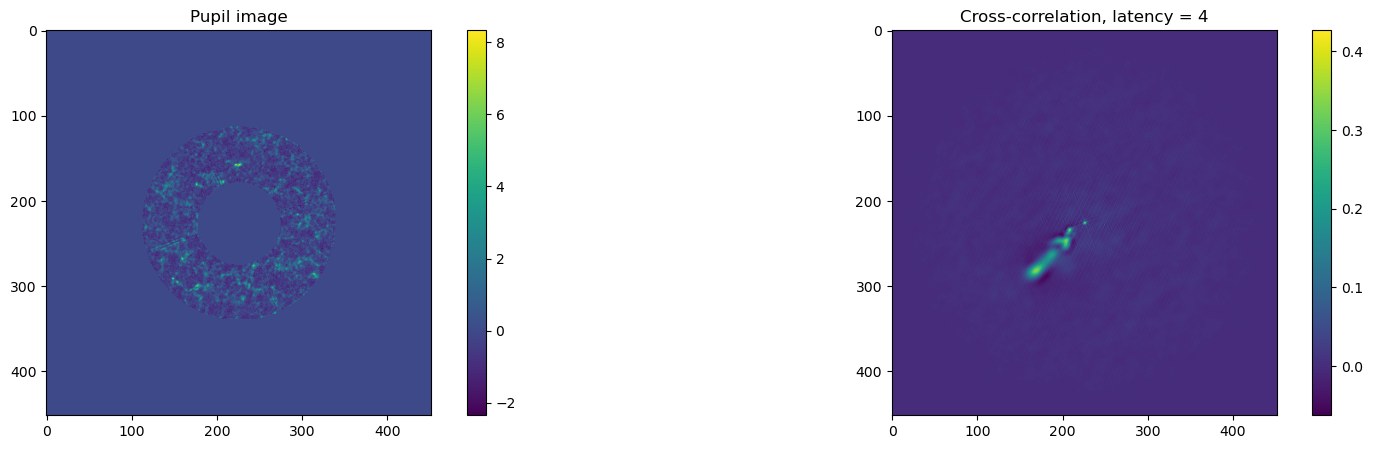

In [3]:
'''Inputs'''

file = '20210130l_m2km.fits'      # файл с объектом
file_bias = 'bias20210130.fits'   # файл с кадром смещения, bias
corr_latency = 4                  # задержка в кросс-корреляции, [кол-во кадров]
pupil_diameter = 2.5              # диаметр телескопа, [м]

df, data_corr = pupil_cc(file, file_bias=file_bias, pupil_diameter=pupil_diameter, corr_latency=corr_latency, method='new')

In [ ]:
# ------------------------- Глобальные переменные -------------------------
cjk, nx = c_jk() # c_jk, nx - размер окна автокорреляции

f_scale = frame.shape[0]/(D*nx) # шаг по частоте
delta = D/frame.shape[0] # шаг по пикселю/субапертуре или же просто размер одного пикселя

fx = f_scale * np.meshgrid(np.linspace(-nx//2, nx//2-1, nx), np.linspace(-nx//2, nx//2-1, nx))[0]
fy = f_scale * np.meshgrid(np.linspace(-nx//2, nx//2-1, nx), np.linspace(-nx//2, nx//2-1, nx))[1]

f_11_3 = abs_f(fx, fy) # |f|^11/3
A_f = aperture_func(fx, fy, delta) # A(f)

z = 2000 # дистанция распространения, [м]

resp_f = np.loadtxt('C:/astro/domecam/resp_f.gz') # Функция отклика
lambda_max = resp_f[0][-1] # Максимальное значение по длине волны
f_lambda = resp_f[1] # Значения функции отклика

a = int(2*frame.shape[0]+2 - frame.shape[0])//2
b = int(2*frame.shape[1]+2 - frame.shape[1])//2
data = np.pad(data_corr, ((a, a), (b, b)), 'constant', constant_values=(0))
x = np.linspace(-data.shape[1]//2, data.shape[1]//2-1, data.shape[1])
y = np.linspace(-data.shape[0]//2, data.shape[0]//2-1, data.shape[0])
X, Y = np.meshgrid(x, y) # Сетка для функций Гамм (будет нужна позже)

In [ ]:
'''Отрисовка подкупольной турбулентности'''

def dome_turbulence(speckle_coords=None, data_corr=None, type_='mono', lambda_=None):
    global X, Y, corr_latency
    Cn2_ex = 1*pow(10, -13)
    Vx = 0
    Vy = 0
    x = speckle_coords[1]
    y = speckle_coords[0]
    if type_ == 'mono':
        input_lambda = lambda_
        k = data_corr[y, x] / np.max((gamma_mono(X, Y, Vx, Vy, Cn2_ex, z, input_lambda)))
        Cn2 = Cn2_ex * k 
        gamma_new = gamma_mono(X, Y, Vx, Vy, Cn2, z, input_lambda)
        tit = 'Dome turbulence, monochromatic scintillation'
        
    if type_ == 'poly':
        k = data_corr[y, x] / np.max((gamma_poly(X, Y, Vx, Vy, Cn2_ex, z)))
        Cn2 = Cn2_ex * k 
        gamma_new = gamma_poly(X, Y, Vx, Vy, Cn2, z) 
        tit = 'Dome turbulence, polychromatic scintillation'
        

    centr = np.unravel_index(np.argmax(gamma_new), gamma_new.shape)

    X1 = data_corr[:, data_corr.shape[1]//2]
    Y1 = range(data_corr.shape[0])
    X3 = gamma_new[centr[0]-data_corr.shape[0]//2-1:centr[0]+data_corr.shape[0]//2, gamma_new.shape[1]//2]
    Y3 = range(data_corr.shape[0])

    fig, (ax, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(30, 5))
    fig.colorbar(ax.imshow(data_corr[y-40:y+40, x-40:x+40]), ax = ax)
    ax.scatter(x=data_corr[y-40:y+40, x-40:x+40].shape[1]//2, y=data_corr[y-40:y+40, x-40:x+40].shape[0]//2, 
               label='Dome turbulence', alpha=0.5, s=30, color='red')
    ax.legend()
    ax.grid(False)

    fig.colorbar(ax2.imshow(gamma_new[centr[0]-40:centr[0]+40, 
                                      centr[1]-40:centr[1]+40]), ax=ax2)
    ax2.grid(False)

    ax3.plot(X1, Y1, alpha = 1, label = 'original corr', color = 'black')
    ax3.plot(X3, Y3, alpha = 0.7, ls = '--', label = 'corected gamma', color = 'red')
    ax3.legend(['Data', 'Speckle model'], loc=1, prop={'size': 12})
    ax3.grid(color = 'black', linestyle='--', alpha = 0.2)
    fig.colorbar(ax4.imshow(data_corr[y-40:y+40, x-40:x+40] - gamma_new[centr[0]-40:centr[0]+40, centr[1]-40:centr[1]+40]),
                ax=ax4)

    # fig.savefig('C:/astro/teor_corr2.png', bbox_inches='tight')

    ax.set_title('Data')
    ax2.set_title('Speckle model')
    ax3.set_title('Comparison')
    ax4.set_title('Residuals')
    fig.text(0.15, -0.05, f'{tit}\n\
latency: {corr_latency}\n\
Cn2 value: {Cn2}')
#     fig.savefig(f'C:/astro/domecam/dome_turb{corr_latency}_abs.png', bbox_inches='tight')
    print(tit)
    print('Cn2 value:', Cn2)

lambda_ = 500 * pow(10, -9) # длина волны для монохроматического случая, [м]
dome_turbulence(speckle_coords=[113, 113], data_corr=data_corr, type_='poly', lambda_=None) # 'poly' or 'mono2

In [ ]:
# '''Аппроксимация спеклов'''

# def multi_speckle_fit(params=None):
#     global data, xdata, ydata, sec_per_frame, latency, delta, z, X, Y
#     def speckle_fit(xcoord, ycoord, Cn2_ex, z_dist): # аппроксимация одного слоя
#         def _g(M, *args): # обходной способ, именно эту функцию будем аппроксимировать
#             x, y = M
#             arr = np.zeros(x.shape)
#             for i in range(len(args)//4):
#                 arr += gamma_poly(x, y, *args[i*4:i*4+4]).ravel()       
#             return arr
        
#         params = [(xcoord, ycoord, Cn2_ex, z_dist)] # подгонка типа ввода параметров под функцию
#         p0 = [p for prms in params for p in prms]
        
#         st=time.perf_counter()
        
#         fit = np.zeros(X.shape) # результирующее изображение
        
#         xdata = np.vstack((X.ravel(), Y.ravel())) # значения аргумента
#         ydata = data.ravel() # целевые значения для аппроксимации
        
#         if z_dist == z:
#             fit = gamma_poly(X, Y, 0, 0, 2.88e-12, 2000)
#             popt = [0, 0, 2.88e-12, z]
            
#         if z_dist != z:
#             popt, pcov = curve_fit(_g, xdata, ydata, p0, bounds=[[xcoord-5, ycoord-5, 0, 0],
#                                                                  [xcoord+5, ycoord+5, 1*pow(10, -11), 100000]]) 
#             print('Fitted parametrs:', popt)
#             for i in range(len(popt)//4):
#                 fit += gamma_poly(X, Y, *popt[i*4:i*4+4])

#         print('Time:', time.perf_counter()-st)
    
#         t = sec_per_frame * latency
#         Xpix = int(popt[0]*t/delta)
#         Ypix = int(popt[1]*t/delta)
    
#         return fit, Xpix, Ypix, popt[2]
    
#     myParams = [p for prms in params for p in prms]
    
#     res = np.zeros(data.shape)
#     cr = data.shape[0]//2 # центр изображения
#     Xc = []
#     Yc = []
#     Cn2 = []
    
#     for i in range(len(myParams)//4):
#         print(f'\nSpeckle N.{i+1}:', *myParams[i*4:i*4+4])
#         fit, xcoord, ycoord, Cn2_fitted = speckle_fit(*myParams[i*4:i*4+4])
#         res += fit
#         Xc.append(xcoord)
#         Yc.append(ycoord)
#         Cn2.append(Cn2_fitted)
#         print('-max fitted value:', np.max(fit))
#         print('-max initial value:', np.max(data[cr-ycoord-4:cr-ycoord+4, cr+xcoord-4:cr+xcoord+4]))
    
#     print(' ')
#     print('RMS:', np.sqrt(np.mean((data - res)**2)))
#     lambda_=500*pow(10, -9) # нм
#     k = 2*np.pi/lambda_
#     r0 = pow(0.423*pow(k, 2)*(np.sum(Cn2)), -3/5)
#     print('sum Cn2:', np.sum(Cn2))
#     print('r0, sm:', 100*r0)
#     print('seeing, arcsec:', 0.98 * 206265 * lambda_/r0)
#     return res, Xc, Yc


# # myParams = [(Vx, Vy, Cn2, z)]
# myParams = [( 0,   0,   2.887430620123135e-12, z),
#             (-7.5, -7.5, 1*pow(10, -12), 12000),
#             (-15, -15,   1*pow(10, -12), 16000)]

# fit, speckle_x, speckle_y = multi_speckle_fit(params=myParams)

# # ------------ Отрисовка ---------------------------
# fig, (ax, ax2, ax3) = plt.subplots(1, 3, figsize=(25, 5))

# cr = data[a:data.shape[0]-a, b:data.shape[1]-b].shape[0]//2 # центр изображения
# v = (D / frame.shape[0]) / (latency * sec_per_frame)
# x = np.round(v*np.linspace(-frame.shape[0]//2+1, frame.shape[0]//2, 5), 2)
# y = np.round(v*np.linspace(-frame.shape[0]//2+1, frame.shape[0]//2, 5), 2)
# y = np.flipud(y)

# fig.colorbar(ax.imshow(data[a:data.shape[0]-a, b:data.shape[1]-b]), ax=ax)
# ax.set_title('Исходные данные')
# ax.set_xticks(np.linspace(0, data[a:data.shape[0]-a, b:data.shape[1]-b].shape[1], 5))
# ax.set_yticks(np.linspace(0, data[a:data.shape[0]-a, b:data.shape[1]-b].shape[0], 5))
# ax.set_xticklabels(x)
# ax.set_yticklabels(y)
# ax.set_ylabel('Vy, m/s')
# ax.set_xlabel('Vx, m/s')


# for i in range(len(speckle_x)):
#     ax.scatter(cr+speckle_x[i], cr-speckle_y[i], alpha=0.9, s=80, facecolors='none', edgecolors='r')
    
# fig.colorbar(ax2.imshow(fit[a:fit.shape[0]-a, b:fit.shape[1]-b]), ax=ax2)
# ax2.set_title('Апроксимация')
# ax2.set_xticks(np.linspace(0, fit[a:fit.shape[0]-a, b:fit.shape[1]-b].shape[1], 5))
# ax2.set_yticks(np.linspace(0, fit[a:fit.shape[0]-a, b:fit.shape[1]-b].shape[0], 5))
# ax2.set_xticklabels(x)
# ax2.set_yticklabels(y)
# ax2.set_ylabel('Vy, m/s')
# ax2.set_xlabel('Vx, m/s')

# fig.colorbar(ax3.imshow((data-fit)[a:data.shape[0]-a, b:data.shape[1]-b]), ax=ax3)
# ax3.set_title('Разность')
# ax3.set_xticks(np.linspace(0, (data-fit)[a:data.shape[0]-a, b:data.shape[1]-b].shape[1], 5))
# ax3.set_yticks(np.linspace(0, (data-fit)[a:data.shape[0]-a, b:data.shape[1]-b].shape[0], 5))
# ax3.set_xticklabels(x)
# ax3.set_yticklabels(y)
# ax3.set_ylabel('Vy, m/s')
# ax3.set_xlabel('Vx, m/s')
# print('')
# # fig.savefig('C:/astro/approx.png', bbox_inches='tight')

In [ ]:
'''Отрисовка спектрального фильтра и функции отклика для отчета'''

omega_new = sfilter(z=z)  

fig, (ax1, ax3) = plt.subplots(1, 2, figsize=(25, 5))

ax1.plot(resp_f[0], resp_f[1], c='black', label='F(λ)')
ax1.set_xlabel('λ, nm')
ax1.legend()
ax1.grid(color = 'black', linestyle='--', alpha = 0.2)

fig.colorbar(ax3.imshow(omega_new, cmap='gray'), ax=ax3)
ax3.grid(False)
x = np.round(np.linspace(-0.2, 0.2, 5), 2)
ax3.set_xticks(np.linspace(0, omega_new.shape[1], 5))
ax3.set_yticks(np.linspace(0, omega_new.shape[0], 5))
ax3.set_xticklabels(x)
ax3.set_yticklabels(x)
ax3.set_xlabel('frequency, 1e5 m^-1')
ax3.set_ylabel('frequency, 1e5 m^-1')

# fig.savefig('C:/astro/response_func.png', bbox_inches='tight')
print(' ')

In [ ]:
'''Отрисовка спеклов для отчета'''

def draw_correlate_with_velocity(data, D, Dpix, latency, sec_per_frame): 
    v = (D / Dpix) / (latency * sec_per_frame)
    x = np.round(v*np.linspace(-data.shape[0]//2+1, data.shape[0]//2, 5), 2)
    y = np.round(v*np.linspace(-data.shape[0]//2+1, data.shape[0]//2, 5), 2)
    y = np.flipud(y)
    fig = plt.figure()
    ax = plt.axes()
    im = plt.imshow(data, cmap = None)
    ax.set_xticks(np.linspace(0, data.shape[1], 5))
    ax.set_yticks(np.linspace(0, data.shape[0], 5))
    ax.set_xticklabels(x)
    ax.set_yticklabels(y)
    ax.set_ylabel('Vy, m/s')
    ax.set_xlabel('Vx, m/s')
    cax = fig.add_axes([ax.get_position().x1+0.01,ax.get_position().y0,0.02,ax.get_position().height])
    plt.colorbar(im, cax=cax)
#     ax.grid(color='grey', linestyle='--', linewidth=0.7, alpha=0.4)
    fig.savefig('C:/astro/cross_corr_m2.png', bbox_inches='tight')

draw_correlate_with_velocity(data_corr, D, frame.shape[0], latency, sec_per_frame)